# Documentation on 2018-11-18

inputs:
- mexico: 
    - city (metropolitan area) boundary and population: 
        - most of the cities: http://www.conapo.gob.mx/es/CONAPO/Datos_Abiertos_Delimitacion_de_Zonas_Metropolitanas
        - for Culiacán Rosales, Sinaloa: this city isn't in the list of metropolitan areas. 
        Use the localidades defined in http://www.inegi.org.mx/geo/contenidos/geoestadistica/m_g_0.aspx:
            - it can't be accessed now. The data link is still working: 
            [State Geostatistics Areas (7.6 MB)](http://mapserver.inegi.org.mx/MGN/mge2014v6_2.zip); [Municipal Geostatistics Areas (37.8 MB)](http://mapserver.inegi.org.mx/MGN/mgm2014v6_2.zip); [Polygons of Urban Geostatistical Locations (13.7 MB)](http://mapserver.inegi.org.mx/MGN/mglu2014v6_2.zip);[Points of Rural Locations (8.2 MB)](http://mapserver.inegi.org.mx/MGN/mglr2014v6_2.zip)
        - population of localidade provided in: http://www.microrregiones.gob.mx/catloc/LocdeMun.aspx?tipo=clave&campo=loc&ent=25&mun=006
    - city list is from ENVIPE 2011
- colombia
    - city (MGN_URB_AREA_CENSAL) boundary: https://geoportal.dane.gov.co/?descarga-marco-geoestadistico-nacional (2017 validity). (was: https://geoportal.dane.gov.co/v2/?page=elementoDescargaMGN)
    - population in 2012: ECSC 2012 (http://www.dane.gov.co/index.php/estadisticas-por-tema/seguridad-y-defensa/encuesta-de-convivencia-y-seguridad-ciudadana-ecsc/resultados-2012)
    - the list of 25 cities(20 dominios geográficos) is from ECSC 2012 

        
outputs:
- geojson: cities_mexico.geojson, cities_colombia.geojson
- Csv: city names, city id and city population. cities_mexico.csv, cities_colombia.csv
- html: cities_mexico.html, cities_colombia.html


columns in geojson:
- cname: city name as index
- city id: 
    - cve_sun for mexico
    - CPOB_CCDGO for colombia
- population: 
    - metropolitan population(sum of member municipalities) in 2010 for mexico
    - ECSC 2012 population for Colombia
- geometry: boundaries of cities(could be multipolygons)


In [1]:
import pandas as pd
import geopandas as gp
from src.utils.map_vis import geojson_per_row
import folium
from shapely.ops import cascaded_union
from shapely.geometry import Polygon, MultiPolygon

In [2]:
num_cities = 16

# Colombia

In [3]:
shp_munic = gp.read_file('data/colombia/MGN/ADMINISTRATIVO/MGN_MPIO_POLITICO.shp')
col_munic = ['DPTO_CCDGO','MPIO_CCDGO', 'MPIO_CNMBR', 'DPTO_CNMBR', 'geometry']

# CLAS_CCDGO: 1-Municipal Headboard 2-populated center 3-scattered rural area 
# 1-Cabecera municipal, 2-Centro poblado y 3-Área rural dispersa.
shp_urb_censal = gp.read_file('data/colombia/MGN/MGN_URB_AREA_CENSAL.shp')
shp_urb_censal=shp_urb_censal.merge(shp_munic[col_munic[:-1]], how='left')
print(shp_urb_censal.shape)
shp_urb_censal.head()

(7627, 16)


,OBJECTID,DPTO_CCDGO,MPIO_CCDGO,CLAS_CCDGO,SETR_CCDGO,SECR_CCDGO,CPOB_CCDGO,CPOB_CNMBR,CPOB_CCNCT,CPOB_NAREA,CPOB_NALT,Shape_Leng,Shape_Area,geometry,MPIO_CNMBR,DPTO_CNMBR
0,1,05,05001,2,000,00,05001004,SANTA ELENA,05001200000004,0.338461,2540.0,0.034407,0.000028,POLYGON ((-75.49783904499998 6.207774365000034...,MEDELLÍN,ANTIOQUIA
1,2,05,05001,2,000,00,05001014,BARRO BLANCO,05001200000014,0.534495,2531.0,0.044447,0.000044,POLYGON ((-75.47379840599996 6.239590113000077...,MEDELLÍN,ANTIOQUIA
2,3,05,05001,2,000,00,05001015,EL CERRO,05001200000015,0.414935,2668.0,0.042879,0.000034,(POLYGON ((-75.49121943999995 6.20501584900006...,MEDELLÍN,ANTIOQUIA
3,4,05,05001,2,000,00,05001018,EL PLACER,05001200000018,0.965299,2598.0,0.056312,0.000079,"POLYGON ((-75.49276999399996 6.23050003000003,...",MEDELLÍN,ANTIOQUIA
4,5,05,05001,2,000,00,05001019,EL PLAN,05001200000019,3.252561,2700.0,0.093795,0.000266,POLYGON ((-75.50917742799999 6.195200505000059...,MEDELLÍN,ANTIOQUIA


### cities in ECSC 2012 
http://www.dane.gov.co/index.php/estadisticas-por-tema/seguridad-y-defensa/encuesta-de-convivencia-y-seguridad-ciudadana-ecsc/resultados-2012

In [4]:
# from ecsc 2012
populations = {'Armenia': 284300, 'Barranquilla - Soledad': 1765291, 'Bogotá D.C. - Soacha': 7568056, 'Bucaramanga': 519499, 'Cali - Palmira': 2212707, 'Cartagena': 924925, 'Cúcuta': 610424, 'Ibagué': 507989, 'Manizales': 364547, 'Medellín - Envigado - Itagüí': 2788656, 'Montería': 325414, 'Neiva': 316153, 'Pasto': 350051, 'Pereira': 388940, 'Popayán': 240514, 'San Andrés': 51404, 'Santa Marta': 440975, 'Sincelejo': 246580, 'Valledupar': 360864, 'Villavicencio': 413451}

In [5]:
cnames2CPOB={'Armenia': '63001000', 'Barranquilla': '08001000', 'Soledad': '08758000', 'Bogotá D.C.': '11001000', 'Soacha': '25754000', 'Bucaramanga': '68001000', 'Cali': '76001000', 'Palmira': '76520000', 'Cartagena': '13001000', 'Cúcuta': '54001000', 'Ibagué': '73001000', 'Manizales': '17001000', 'Medellín': '05001000', 'Envigado': '05266000', 'Itagüí': '05360000', 'Montería': '23001000', 'Neiva': '41001000', 'Pasto': '52001000', 'Pereira': '66001000', 'Popayán': '19001000', 'San Andrés': '88001000', 'Santa Marta': '47001000', 'Sincelejo': '70001000', 'Valledupar': '20001000', 'Villavicencio': '50001000'}
merge_cities = [('Barranquilla', 'Soledad'), ('Bogotá D.C.', 'Soacha'), ('Cali','Palmira'), ('Medellín', 'Envigado', 'Itagüí')]

cities = []
# get shapes for pairs
for pairs in merge_cities:
    cpobs = []
    for c in pairs:
        cpobs.append(cnames2CPOB.pop(c))
    c_in_pairs = shp_urb_censal[shp_urb_censal.CPOB_CCDGO.isin(cpobs)]
    geometry = cascaded_union(c_in_pairs.geometry.tolist())
    cname = ' - '.join(pairs)
    cpobs = ' - '.join(cpobs)
    pop = populations[cname]
    cities.append({'cname':cname, 'population':pop, 'CPOB_CCDGO': cpobs, 'geometry':geometry})

# get the rest (single cities)
for cname, cpob in cnames2CPOB.items():
    c = shp_urb_censal[shp_urb_censal.CPOB_CCDGO==cpob]
    assert len(c)==1
    geometry = c.geometry.values[0]
    pop = populations[cname]
    cities.append({'cname':cname, 'population':pop, 'CPOB_CCDGO': cpob, 'geometry':geometry})


In [6]:
target_cities = gp.GeoDataFrame(cities).sort_values('population', ascending=False)

### deprecated on 2018-10-30 ↓
the list of cities comes from ECSC 2012 instead of the thresholded population

In [46]:


# population = pd.read_csv('data/colombia/population_2005.csv',sep='\t')
# cols = ['TOTAL_2005','CABECERA_2005', 'RESTO_2005']
# for col in cols:
#     population[col] = population[col].apply(lambda x: float(x.replace(',', '')))

# population['CABECERA_pcnt'] = population.CABECERA_2005/population.TOTAL_2005
# population.sort_values('TOTAL_2005', ascending=False, inplace=True)
# population['pop_order'] = pd.np.arange(population.shape[0])+1
# population.DPMP = population.DPMP.apply(lambda x: '%05d' % x)
# thres = 0.8
# target_munic = population[population.CABECERA_pcnt>thres].head(num_cities)


In [6]:
# target_cities = shp_urb_censal.merge(target_munic, left_on='MPIO_CCDGO', right_on='DPMP')  # deprecated on 2018-10-30
# target_cities = target_cities[target_cities.CLAS_CCDGO=='1'].copy()
# target_cities['CABECERA_2005'] = target_cities['CABECERA_2005'].astype(int)
# target_cities['cname'] = target_cities['CPOB_CNMBR'].apply(lambda x: x.split(',')[0]) + ', ' + target_cities['DPTO_CNMBR']

# cols = ['OBJECTID', 'DPTO_CCDGO', 'MPIO_CCDGO', 'CLAS_CCDGO', 'CPOB_CCDGO', 'MPIO_CNMBR', 'MPIO', 'CPOB_CNMBR', 'CPOB_NAREA', 'TOTAL_2005',
#        'CABECERA_2005', 'RESTO_2005', 'CABECERA_pcnt', 'pop_order', 'geometry']

# target_cities = target_cities[cols]

In [7]:
# less_cols = ['CPOB_CCDGO', 'cname', 'CABECERA_2005', 'geometry'] 
# rename_cols = ['CPOB_CCDGO', 'cname', 'population', 'geometry']
# target_cities = target_cities[less_cols]
# target_cities.columns = rename_cols


### deprecated ↑

In [7]:
target_cities.to_file('data/cities_colombia.geojson', driver="GeoJSON")

In [8]:
target_cities.set_index('cname').drop('geometry', axis=1).to_csv('data/cities_colombia.csv')

In [9]:
some_map = folium.Map(location=[4.149624, -72.795576], zoom_start=6)
# deprecated columns
# geojson_per_row(target_cities, name='cities', tip_cols=['CPOB_CCDGO', 'MPIO_CNMBR', 'MPIO', 'CPOB_CNMBR'], some_map=some_map)
geojson_per_row(target_cities, name='cities', tip_cols=['cname', 'population', 'CPOB_CCDGO'], some_map=some_map)
folium.LayerControl().add_to(some_map)
some_map.save('data/cities_colombia.html')

# Mex

## 2018-10-30 decided to used metropolitan area instead

In [10]:
metro = gp.read_file('data/mexico/Mapa_de_delimitacion_de_zonas_metropolitanas_2010/ZM_2010.shp')
sun_ids = [31, 21, 32, 28, 24, 11, 12, 41, 37, 3, 17,2,25,45]
sun_names = ['Monterrey, Nuevo León', 'Guadalajara, Jalisco', 'Oaxaca de Juárez, Oaxaca', 'Cuernavaca, Morelos', 'Toluca de Lerdo, México', 'Juárez, Chihuahua', 'Chihuahua, Chihuahua', 'Villahermosa, Tabasco', 'Cancún, Quintana Roo', 'Mexicali, Baja California', 'Acapulco de Juárez, Guerrero', 'Tijuana, Baja California', 'Morelia, Michoacán de Ocampo', 'Nuevo Laredo, Tamaulipas','Culiacán Rosales, Sinaloa', 'Valle de Mexico, Distrito Federal']

suns = []
for cve,name in zip(sun_ids,sun_names):
    sun = metro[metro.CVE_SUN==cve]
    geometry = cascaded_union(sun.geometry.tolist())
    pob = sun.POB_2010.sum()
    suns.append({'cname': name, 'cve_sun': cve, 'population': pob, 'nom_sun':sun.NOM_SUN.unique()[0], 'geometry':geometry})

sun = metro[(metro.CVE_SUN==13) & (metro.CVE_ENT=='09')]
geometry = cascaded_union(sun.geometry.tolist())
pob = sun.POB_2010.sum()
suns.append({'cname': sun_names[-1], 'cve_sun': 13, 'population': pob, 'nom_sun':sun.NOM_SUN.unique()[0], 'geometry':geometry})

## Culiacán Rosales, Sinaloa is not in metropolitan

In [3]:
from src.utils import fix_spanish_encoding

In [4]:
# http://www.inegi.org.mx/geo/contenidos/geoestadistica/m_g_0.aspx
shp_urban = gp.read_file('data/mexico/mglu2014v6_2/mglu2015v6_2.shp')
shp_state = gp.read_file('data/mexico/mge2014v6_2/mge2015v6_2.shp')
shp_munic = gp.read_file('data/mexico/mgm2014v6_2/mgm2015v6_2.shp')

# get Urban id
shp_urban.NOM_LOC = shp_urban.NOM_LOC.apply(fix_spanish_encoding)
shp_urban['URBAN_ID'] = shp_urban.CVE_ENT + shp_urban.CVE_MUN + shp_urban.CVE_LOC

# get the full data frame
shp_all = shp_urban.merge(shp_state.drop('geometry', axis=1)).merge(shp_munic.drop('geometry', axis=1))

### Fix the holes in mexico city, get localidades (used to define cities on 2018-10-04

In [13]:
polys = cascaded_union(shp_all[shp_all.CVE_ENT=='09'].geometry)
p0=polys[0]
p0 = Polygon(p0.exterior, [p0.interiors[115]])
p4 = Polygon(polys[4].exterior)

mex_city_geo = MultiPolygon([p0, p4]+list(polys[1:4]) + list(polys[5:]))

In [14]:
mexico_city = {'CVE_ENT': '09', 'CVE_MUN': '000', 'CVE_LOC': '0000', 
               'NOM_LOC': 'Mexico city in DC', 'NOM_ENT': 'Distrito Federal',
               'NOM_MUN': 'Mexico city in DC', 'concat': '09000', 'URBAN_ID' :'090000000',
               'geometry': mex_city_geo}
mexico_city = gp.GeoDataFrame([mexico_city])

In [15]:
idx = [742, 3396, 454, 431, 2095, 3515, 1186, 48, 2280, 1943, 3815, 2373, 71, 1771, 3709]
selected_localidades_mex = shp_all.loc[idx].append(mexico_city, ignore_index=True, sort=False)

cols = ['URBAN_ID', 'NOM_ENT', 'NOM_MUN','NOM_LOC',  'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'geometry']
selected_localidades_mex = selected_localidades_mex[cols]

In [17]:
# selected_localidades_mex.to_file('data/localidades_mexico_16.geojson', driver="GeoJSON")
# some_map = folium.Map(location=[24.062199, -102.870324], zoom_start=5)
# geojson_per_row(selected_localidades_mex, name='localidades', tip_cols=['URBAN_ID', 'NOM_ENT', 'NOM_MUN','NOM_LOC',], some_map=some_map)
# folium.LayerControl().add_to(some_map)
# some_map.save('data/localidades_mexico_16.html')

In [18]:
culiacan_sinaloa = selected_localidades_mex[selected_localidades_mex.URBAN_ID=='250060001'].to_crs(metro.crs).iloc[0].to_dict()

In [19]:
suns.append({'cname': sun_names[-2], 'cve_sun': 99, 'population': 675773, 'nom_sun':sun_names[-2], 
             'geometry':culiacan_sinaloa['geometry']})

## target cities/metropolitan areas

In [20]:
suns=gp.GeoDataFrame(suns)
suns.crs = metro.crs
suns = suns.to_crs(epsg=4326)

In [21]:
suns = suns[['cname','population', 'cve_sun', 'geometry']].sort_values('population', ascending=False)

In [22]:
suns.to_file('data/cities_mexico.geojson', driver="GeoJSON")

In [24]:
suns.drop('geometry', axis=1).set_index('cname').to_csv('data/cities_mexico.csv')

In [25]:
some_map = folium.Map(location=[24.062199, -102.870324], zoom_start=5)
geojson_per_row(suns.reset_index(), name='cities', tip_cols=['cname','population','cve_sun'], some_map=some_map)
folium.LayerControl().add_to(some_map)
some_map.save('data/cities_mexico.html')

## mexico polygon

In [5]:
%matplotlib inline

In [22]:
%%time
mex = cascaded_union(shp_state.geometry.values)

CPU times: user 44min 52s, sys: 232 ms, total: 44min 53s
Wall time: 44min 53s


In [24]:
mex_gpdf = gp.GeoDataFrame([[mex,]], columns=['geometry'])

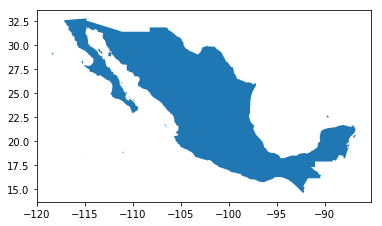

In [25]:
mex_gpdf.plot()

In [28]:
mex_gpdf.to_file('data/mexico.geojson', driver='GeoJSON')